## Assignment 4 -- Applying Machine Learning Algorithms

You will be given a data set, and will apply the techniques we have studied in class to predict a numeric response variable, and to evaluate alternative solutions.

The steps will be

1.  Exploratory data analysis and evaluation
  * Find and correct outliers and missing values
  * Find nonlinear relationships between the independent variables and the dependent variable, and transform the input appropriately
  * Find correlation in the independent variables and decide how if at all to address it
  

2. Apply learning techniques.  In each case you will train the algorithm and evaluate it using the *test* $R^2$ statistic.  You will explore different hyperparameter values to find the model you think will maximize test $R^2$ for an evaluation data set.  You will do this for
  * Linear regression exploring different variable sets using regular stepwise regression, Lasso, and Ridge Regression
  * Decision tree regression exploring different tree depths
  * Random forests and boosting exploring different parameter sets
  * Neural networks 


3. Choosing the best method.  You will choose one algorithm and parameter settings you are most confident with, and write a function that enables it to evaluate a new data set.

4. When I evaluate your solution, I will call this function on a new set of data, and score your solution (partially) on its results

Every part of this assignment has been covered in the notebooks we have looked at in class, so that should be your first source of information and inspiration. 

<b><span style="color: blue">Cells in blue indicate you should fill in your results -- either text or code.</span></b>

When you submit your code, please fill in the cells asked for, but do not add new cells or change the other cells.

I will run the cells in your submitted notebook in sequence, so make sure things are in the proper order, all the needed libraries have been imported, etc.

----------------------------
#### Note on your prediction functions

You will notice that for each technique, you are asked to provide a "prediction" function that takes an **X** matrix as input.  This **X** matrix will be in the format of the original data set you loaded.  So if in your data cleaning phase you added or deleted or transformed column values, each of these prediction functions must make the same transformations on its input prior to calling you model.


---------------------------------------

### Loading and Cleaning the Data Set

The data set is in a file named **data_set.csv** -- it has 11 independent variables -- some are numeric and some categorical -- and a single numeric response variable $y$.

In the first cleaning / analysis phase you should do the following
1. Look for outlier values.  When you find outliers, you can do one of two things
  * Throw away the data row altogether.  If many variables in the row seem uncommon, it is probably best to delete the row.
  * Replace the outlier with a "reasonable" value -- probably the mean or median value for that variable.   The reasoning is that the benefit of keeping the row outweighs the error introduced by having a made-up value in one variable
2. Look for missing values.  Most algorithms will throw away data rows that have *any* missing value.  You can just delete the row (especially if many values are missing) or assign it a "reasonable" value -- probably the mean value for that variable.  If there is an attribute that has many missing values, it is probably best to delete the whole column
3. Look for nonlinear relationships.   Most important is finding nonlinear relationships between one of the $x$ variables, and the $y$ variable.  For example, maybe $y$ depends on $x^2$ or $\log(x)$ rather than on $x$. In that case you need to guess at that relationship, and replace $x$ with a transformed value.  For example if it looks like $y$ depends on $x^2$ then just a column of $x^2$ values.  The easiest way to see these relationships is to do a pair plot between your X variables and y, including a trend line.  "Well behaved" $x$ variables tend to show no pattern except for (roughly) following the trend line.  If you are seeing other shapes, or sudden jumps in the behavior of $y$ as $x$ changes, something nonlinear is going on.
4. Look for correlations among the $x$ variables.  If you find a correlation you may want to delete one of the correlated variables, but it is not necessary -- you will have to experiment to see if it improves your predictions.  To find correlations, you can use the pair plot, or a correlation matrix, or a heatmap -- there are examples of all of these in the class notebooks.
5. Transform categorical variables to dummy (0/1 coded) variables

The result of this phase should be a matrix ${\bf X}$ and a vector ${\bf y}$ that comprise your training set.

Remember though, if you ever need to use your learned function to a new ${\bf X}$ data set, you need to transform the input ${\bf X}$ matrix the same way your transformed your test set -- otherwise your learned function will give bad results.

Although it looks like this cleaning phase happens before any analysis/learning, the two processes are interleaved.  Start with a simple linear regression model and do minimal cleaning on your data set, just to the point the LR model works.  Then you can test more subtle transformations to see if they make your models perform better.

In [1]:
# Your data cleaning code goes here.  The result should be X and y matrices that can be used to run the models you build below
import pandas as pd
import numpy as np
import seaborn as sns #statistic/visualization
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 14


In [2]:
# Get rid of rows with invalid values
def correctDummies(df):
    df['x4'] = df['x4'].replace('f' , 'false')
    df['x4'] = df['x4'].replace('t', 'true')
    df['x4'] = df['x4'].replace('rue', 'true')
    df['x3'] = df['x3'].fillna((df['x3']).mean()) # replace all missing values in x3 with mean
    df = df.dropna(subset = ['x9']) # too many na's in x9 so drop all of them
    df = df[df.x2.isin(['r', 'b', 'y'])]
    return df

#  Add the dummy variables and get rid of x2 and x4.   Has to be done after correctDummies!
def convertDummies(df):
    dfnew = df.copy()
    x2_dummies = pd.get_dummies(dfnew.x2, prefix='x2')
    x4_dummies = pd.get_dummies(dfnew.x4, prefix='x4')
    
    x2_dummies.drop(x2_dummies.columns[0], axis=1, inplace=True)
    x4_dummies.drop(x4_dummies.columns[0], axis=1, inplace=True)
    
    dfnew.drop(['x2','x4'], axis=1, inplace=True)
    
    dfnew = pd.concat([dfnew, x2_dummies], axis=1)
    dfnew = pd.concat([dfnew, x4_dummies], axis=1)
    return dfnew

def deal_with_nonlinearities(df):
    df['x5_big'] = df['x5']
    df.loc[df['x5'] <= 410, 'x5_big'] = 0.0
    df['x5_small'] = df['x5']
    df.loc[df['x5'] > 410, 'x5_small'] = 0.0
    
    df['x8_square'] = df['x8'] * df['x8']
    
    df.drop(['x5'],axis = 1, inplace = True)
    df.drop(['x8'],axis = 1, inplace = True)
    
    return df
    

In [3]:
from scipy import stats

def cleandf(df):
    df.dropna(inplace=True)
    df = correctDummies(df)
    df = convertDummies(df)
    df = deal_with_nonlinearities(df)
    df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    return df

In [4]:
file_location = 'data_set_test.csv'
df = pd.read_csv(file_location, dtype={'x4': str})

df = cleandf(df)
y = df.y
X = df.drop(['y'], axis=1, inplace=False)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6317, 13) (6317,)
(2106, 13) (2106,)


-----------------------------
#### <span style="color: blue">*Your Summary of EDA / Cleaning Phase*</span>

<span style="color: blue">

*In this markdown cell please write up the transformations you made to the data set, and why you decided to make those transformations.*

</span>

---------------------------------

In the following cells you will try various learning techniques on your data set.  For each one you will finish with a prediction function for your best model.  For example for linear regression you will define a function **linear_regression_predict(X)** which will produce the predicted $y$ values for your model.  Remember that the **X** argument is un-transformed.

-----------------------------------------
### Linear Regression

In this section you will try linear regression, and also use Lasso, Ridge Regression and Forward Stepwise Regression to find the set of variables that give you the best $R^2$ score.   You will produce a markdown summary, then implementations of your four models


#### <span style="color: blue">Summary of Your Linear Regression Models</span>
<span style="color: blue">
In this markdown cell, summarize your results in building linear regression models for this data set.
For each method (full-model regression, forward stepwise regression, Lasso, and Ridge regression) report on the best model:  the variables in the model, the adjusted $R^2$, the estimated test accuracy, and in the case of Lasso, the optimal $\alpha$ value.  Can you explain the differences in the structure and performance of the alternative models?
</span>

In [12]:
# This code cell should define a function linear_regression_predict(x_matrix)
from sklearn.linear_model import LinearRegression
from sklearn import metrics

lr = LinearRegression()
lr.fit(X_train, y_train)

def linear_regression_predict(xdf):
    return lr.predict(xdf)

y_train_predicted = linear_regression_predict(X_train)
y_test_predicted = linear_regression_predict(X_test)
y_pred = linear_regression_predict(X)

print("Training MSE")
print(metrics.mean_squared_error(y_train, y_train_predicted))
print(metrics.r2_score(y_train, y_train_predicted))
print("Sample Test MSE")
print(metrics.mean_squared_error(y_test, y_test_predicted))
print(metrics.r2_score(y_test, y_test_predicted))

#sum(treeclf.predict(X) == y) / len(y) ------ for accuracy
print("Accuracy: ")
print(lr.score(X,y))
print(metrics.r2_score(y, y_pred))
#print(y_pred)

Training MSE
296860890.4790123
0.9577781747538766
Sample Test MSE
309621414.45298856
0.9558749285490428
Accuracy: 
0.9573183719560532
0.9573183719560532


In [10]:
# This code cell should define a function stepwise_regression_predict(x_matrix)
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.linear_model import LinearRegression

def forward_selected(data, response):
    
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
                
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    
    formula = "{} ~ {} + 1".format(response,' + '.join(selected))
    model = smf.ols(formula, data).fit()
    
    return model,selected

best_model,x_vars = forward_selected(df, "y")

#R2 = 0.957
def stepwise_regression_predict(xdf):
    return best_model.predict(xdf)

y_train_predicted = stepwise_regression_predict(X_train)
y_test_predicted = stepwise_regression_predict(X_test)
y_pred = stepwise_regression_predict(X)

print("Training MSE")
print(metrics.mean_squared_error(y_train, y_train_predicted))
print(metrics.r2_score(y_train, y_train_predicted))
print("Sample Test MSE")
print(metrics.mean_squared_error(y_test, y_test_predicted))
print(metrics.r2_score(y_test, y_test_predicted))


Training MSE
297062087.0868931
0.9577495590342231
Sample Test MSE
308397042.39150476
0.9560494174641294
Accuracy: 
0.0
0       289137.019149
1       172006.006951
2       130036.827100
3       245126.168275
4       223268.342115
5       120419.754465
6       110900.862958
8       180929.276800
9       234406.384877
11      118354.667763
12      296571.953643
13      300696.396251
14      300403.741852
16      111158.879553
17      220816.391709
18      324475.514182
19      254340.021077
20      260842.031022
21      339023.462337
22      240674.175018
23      241561.956645
24      442449.069894
25      328351.052976
26      173396.626216
27      100577.207540
28      272966.586412
29      102156.162632
30      250243.801746
31      171703.851805
32      281397.989468
            ...      
9967    369752.226750
9968    214207.945710
9969    287293.085054
9970    188192.297365
9971    299861.536796
9972    183572.421095
9973    327009.643262
9974    210840.654838
9975    173194.939618
9

In [27]:
'''import statsmodels.api as sm

def statsmodel_summary(dataset, columns):
    X = sm.add_constant(dataset[columns])
    Y = dataset['y']
    results = sm.OLS(y, X).fit()
    print(results.summary())
    
statsmodel_summary(df, ['x5_big', 'x1', 'x8_square', 'x3', 'x2_y', 'x2_r', 'x5_small', 'x9',
       'x4_true', 'x10'])'''

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                 1.888e+04
Date:                Thu, 21 Mar 2019   Prob (F-statistic):               0.00
Time:                        00:14:33   Log-Likelihood:                -94156.
No. Observations:                8423   AIC:                         1.883e+05
Df Residuals:                    8412   BIC:                         1.884e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.283e+05   2.72e+04     -8.391      0.0

In [13]:
from sklearn import linear_model
for a in [.10, .25, .35, .50, .65, .75, .85, .9, .95, .99, 1.0]:
    clf = linear_model.Lasso(alpha=a)
    clf.fit(X_test,y_test)
    r2 = clf.score(X_test,y_test)
    coef_count = len(list(filter(lambda x: (x < -.001) | (x > .001), clf.coef_)))
    print("Alpha: {}, R2: {}, Terms: {}".format(a, r2, coef_count))

Alpha: 0.1, R2: 0.9584111209498068, Terms: 13
Alpha: 0.25, R2: 0.9584111202589931, Terms: 13
Alpha: 0.35, R2: 0.9584111195173933, Terms: 13
Alpha: 0.5, R2: 0.9584111179834078, Terms: 13
Alpha: 0.65, R2: 0.9584111159435195, Terms: 13
Alpha: 0.75, R2: 0.9584111143025368, Terms: 13
Alpha: 0.85, R2: 0.9584111124367081, Terms: 13
Alpha: 0.9, R2: 0.9584111114194765, Terms: 13
Alpha: 0.95, R2: 0.9584111103460337, Terms: 13
Alpha: 0.99, R2: 0.9584111094468071, Terms: 13
Alpha: 1.0, R2: 0.9584111092163793, Terms: 13


In [19]:
# This code cell should define a function lasso_predict(x_matrix)
from sklearn import linear_model

# r2 = 0.9573296825234765
def lasso_predict(x_matrix):
    clf = linear_model.Lasso(alpha=0.1)
    clf.fit(x_matrix, y_test)
    return clf.predict(x_matrix)

#y_train_predicted = lasso_predict(X_train)
y_test_predicted = lasso_predict(X_test)

'''print("Training MSE")
print(metrics.mean_squared_error(y_train, y_train_predicted))
print(metrics.r2_score(y_train, y_train_predicted))'''
print("Sample Test MSE")
print(metrics.mean_squared_error(y_test, y_test_predicted))
print(metrics.r2_score(y_test, y_test_predicted))

Sample Test MSE
289560156.48833966
0.9584111209498068


In [14]:
for a in [.10, .25, .35, .50, .65, .75, .85, .9, .95, .99, 1.0]:
    clf = linear_model.Ridge(alpha=a)
    clf.fit(X_train,y_train)
    r2 = clf.score(X_train,y_train)
    coef_count = len(list(filter(lambda x: (x < -.001) | (x > .001), clf.coef_)))
    print("Alpha: {}, R2: {}, Terms: {}".format(a, r2, coef_count))

Alpha: 0.1, R2: 0.9570462859083005, Terms: 13
Alpha: 0.25, R2: 0.9570462858654045, Terms: 13
Alpha: 0.35, R2: 0.9570462858163961, Terms: 13
Alpha: 0.5, R2: 0.9570462857122869, Terms: 13
Alpha: 0.65, R2: 0.9570462855714884, Terms: 13
Alpha: 0.75, R2: 0.957046285457254, Terms: 13
Alpha: 0.85, R2: 0.9570462853267344, Terms: 13
Alpha: 0.9, R2: 0.9570462852553704, Terms: 13
Alpha: 0.95, R2: 0.9570462851799383, Terms: 13
Alpha: 0.99, R2: 0.9570462851166643, Terms: 13
Alpha: 1.0, R2: 0.9570462851004392, Terms: 13


In [15]:
# This code cell should define a function ridge_predict(x_matrix)
from sklearn import linear_model
ridge = linear_model.Ridge(alpha = 0.1)
ridge.fit(X, y)

#r2 = 0.9573439129264358
def ridge_predict(xdf):
    return ridge.predict(xdf)



--------------------------------------
### Decision Tree Regressors and Ensemble Methods

Here you will build decision tree regression learners, and experiment to optimize algorithm parameters.  You will implement learners for 
* Decision trees
* Random forest
* Boosting

#### <span style="color: blue">Summary of Your Decision Tree and Ensemble Method Models</span>
<span style="color: blue">
In this markdown cell, summarize your results in building tree-based models for this data set.
For each method report on the best model:  the model parameters and the estimated test accuracy.
</span>

In [41]:
# This code cell should define a function decision_tree_predict(x_matrix)
from sklearn.tree import DecisionTreeRegressor

treeReg = DecisionTreeRegressor(max_depth = 21)
treeReg.fit(X_train,y_train)

predY = treeReg.predict(X_train)

print(predY)
print(sum(treeReg.predict(X_test) == y_test) / len(y_test))

pd.DataFrame({'feature':X.columns, 'importance':treeReg.feature_importances_})

[147565.24660166 139120.11734913 138943.03834964 ... 199381.40210507
 244833.5636918  349059.31737587]
0.0


,feature,importance
0,x1,0.241265
1,x3,0.074073
2,x6,0.002424
3,x7,0.002848
4,x9,0.003190
5,x10,0.003222
6,x11,0.003492
7,x2_r,0.000414
8,x2_y,0.000533
9,x4_true,0.000593


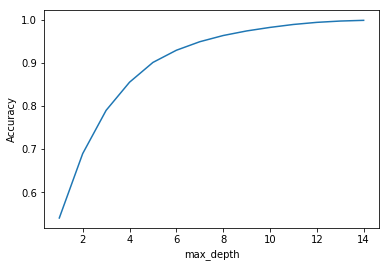

In [44]:
from sklearn.model_selection import cross_val_score
# List of values to try:
max_depth_range = list(range(1, 15))

# List to store the average RMSE for each value of max_depth:
accuracy_scores = []

# Use LOOCV with each value of max_depth.
for depth in max_depth_range:
    treeclass = DecisionTreeRegressor(max_depth=depth, random_state=1)
    treeclass.fit(X_train,y_train)
    new_scores = treeclass.score(X_train, y_train)
    accuracy_scores.append(np.mean(new_scores))
    
plt.plot(max_depth_range, accuracy_scores);
plt.xlabel('max_depth');
plt.ylabel('Accuracy');

In [53]:
# This code cell should define a function random_forest_predict(x_matrix) #typecast with int64 ---  no cast needed


from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_depth= 6, max_features= 11, n_estimators= 300)
forest.fit(X_test, y_test)

def random_forest_predict(xdf):
    return forest.predict(xdf)

predY = random_forest_predict(X_test)
forest.score(X_test, y_test)

#max_depth= 6, max_features= 11, n_estimators= 100

0.9613308355732935

In [49]:
from sklearn.model_selection import GridSearchCV

'''gsc = GridSearchCV(estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(1,7),
            'n_estimators': (10, 50, 100, 300),
            'max_features': range(1,13)
        },
        cv=5,  verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_

print(best_params)'''

{'max_depth': 6, 'max_features': 11, 'n_estimators': 300}


In [20]:
# This code cell should define a function adaboost_predict(x_matrix)
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

'''booster = AdaBoostRegressor()

parameters = {'n_estimators': [1, 2, 10, 25, 40, 50, 60, 75, 100, 200,300,400,500,600,800,1000,1200], 'learning_rate': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1.0]}
clfbooster = GridSearchCV(booster, parameters, cv=5, verbose=0,n_jobs=-1)
clfbooster.fit(X_train, y_train)
[clfbooster.best_estimator_, clfbooster.best_score_]

#Output : [AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
          # n_estimators=1000, random_state=None), 0.926845561598874]''' 

adaBoost = AdaBoostRegressor(learning_rate=1.0, loss='linear',n_estimators=1000)
adaBoost.fit(X,y)

def adaboost_predict(xdf):
    return adaBoost.predict(xdf)

adaBoost.score(X, y)

from sklearn import metrics
print(metrics.mean_squared_error(y,adaboost_predict(X)))

479964420.0942701


------------------------------------
### Neural Networks

For this part you will use the *keras* library to implement a neural net regression function.  You will experiment with the structure of the network to optimze for $R^2$.  Remember that your neural net implements a *predict* method, and you can use *sklearn.metrics.r2_score* to evaluate your model.  

#### <span style="color: blue">Summary of Neural Network Solution</span>
<span style="color: blue">
In this markdown cell, summarize your results in building the neural network predictor, including the estimated test accuracy and the model parameterers
</span>

In [ ]:
# This code cell should define a function neural_network_predict(x_matrix)

### Scoring Your Work
In the following code cell, implement a method best_model_predict(X) where X is the same shape as the original training set in the data file.  I will call this function on a new data set generated by the same function, but not part of the training set.  Use whatever method and parameter settings you think will perform best.   **Remember** the ${\bf X}$ matrix I will call your predict function with will be like the original data matrix, so if you did any transformations on the data set, you will have to do transformation on this matrix too.  It is guaranteed that the data set I used will not have any missing values or deliberate outliers.

In [ ]:
## This code cell should define a function best_model_predict(x_matrix)

In [ ]:
## I will copy code into this cell which will (a) read in the evaluation data frame, 
## (b) call your predict function, and (c) compute a score for your model on my evaluation data set